# Exploratory Data Analysis

Objective:
- Conduct deep dive analysis of sales patterns and trends
- Analyze customer purchasing behavior
- Evaluate product performance across categories
- Identify temporal patterns and seasonality
- Examine geographic distribution of sales
- Uncover actionable business insights

Prerequisites:
- Completed Notebook 00: Setup and Data Overview
- Data loaded and initial quality checks performed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

data_path = 'data/'

fact_sales = pd.read_csv(f'{data_path}fact_sales.csv', encoding='latin-1')
dim_customer = pd.read_csv(f'{data_path}dim_customer.csv', encoding='latin-1')
dim_item = pd.read_csv(f'{data_path}dim_item.csv', encoding='latin-1')
dim_store = pd.read_csv(f'{data_path}dim_store.csv', encoding='latin-1')
dim_time = pd.read_csv(f'{data_path}dim_time.csv', encoding='latin-1')
dim_payment = pd.read_csv(f'{data_path}dim_payment.csv', encoding='latin-1')

print("Data loaded successfully for EDA")
print(f"Analysis ready for {fact_sales.shape[0]:,} transactions")

Data loaded successfully for EDA
Analysis ready for 1,000,000 transactions


## Data Integration

Creating a denormalized master dataset by joining fact table with all dimension tables for easier analysis.

In [2]:
master_df = fact_sales.copy()

master_df = master_df.merge(
    dim_customer, 
    left_on='coustomer_key', 
    right_on='coustomer_key', 
    how='left',
    suffixes=('', '_customer')
)

master_df = master_df.merge(
    dim_item, 
    left_on='item_key', 
    right_on='item_key', 
    how='left',
    suffixes=('', '_item')
)

master_df = master_df.merge(
    dim_store, 
    left_on='store_key', 
    right_on='store_key', 
    how='left'
)

master_df = master_df.merge(
    dim_time, 
    left_on='time_key', 
    right_on='time_key', 
    how='left'
)

master_df = master_df.merge(
    dim_payment, 
    left_on='payment_key', 
    right_on='payment_key', 
    how='left'
)

print("Master dataset created successfully")
print(f"Shape: {master_df.shape[0]:,} rows, {master_df.shape[1]} columns")
print(f"\nColumns in master dataset:")
print(master_df.columns.tolist())

Master dataset created successfully
Shape: 1,000,000 rows, 30 columns

Columns in master dataset:
['payment_key', 'coustomer_key', 'time_key', 'item_key', 'store_key', 'quantity', 'unit', 'unit_price', 'total_price', 'name', 'contact_no', 'nid', 'item_name', 'desc', 'unit_price_item', 'man_country', 'supplier', 'unit_item', 'division', 'district', 'upazila', 'date', 'hour', 'day', 'week', 'month', 'quarter', 'year', 'trans_type', 'bank_name']


## Temporal Analysis

Analyzing sales patterns across different time dimensions to identify trends, seasonality, and anomalies.

In [3]:
master_df['date_parsed'] = pd.to_datetime(master_df['date'], format='%d-%m-%Y %H:%M')
master_df['year_month'] = master_df['date_parsed'].dt.to_period('M')
master_df['date_only'] = master_df['date_parsed'].dt.date

print("Date parsing complete")
print(f"\nDate range: {master_df['date_parsed'].min()} to {master_df['date_parsed'].max()}")
print(f"\nSample of parsed dates:")
print(master_df[['date', 'date_parsed', 'year_month', 'year', 'month', 'day']].head(10))

Date parsing complete

Date range: 2014-01-20 14:06:00 to 2021-01-23 04:38:00

Sample of parsed dates:
               date         date_parsed year_month  year  month  day
0  26-04-2016 17:13 2016-04-26 17:13:00    2016-04  2016      4   26
1  11-06-2018 19:08 2018-06-11 19:08:00    2018-06  2018      6   11
2  19-11-2016 08:19 2016-11-19 08:19:00    2016-11  2016     11   19
3  01-02-2020 06:00 2020-02-01 06:00:00    2020-02  2020      2    1
4  15-07-2014 02:58 2014-07-15 02:58:00    2014-07  2014      7   15
5  25-06-2019 15:36 2019-06-25 15:36:00    2019-06  2019      6   25
6  17-12-2019 01:12 2019-12-17 01:12:00    2019-12  2019     12   17
7  16-11-2017 07:07 2017-11-16 07:07:00    2017-11  2017     11   16
8  16-10-2016 05:49 2016-10-16 05:49:00    2016-10  2016     10   16
9  13-02-2018 01:12 2018-02-13 01:12:00    2018-02  2018      2   13


In [4]:
monthly_revenue = master_df.groupby('year_month').agg({
    'total_price': 'sum',
    'payment_key': 'count',
    'coustomer_key': 'nunique'
}).reset_index()

monthly_revenue.columns = ['year_month', 'revenue', 'transactions', 'unique_customers']
monthly_revenue['avg_order_value'] = monthly_revenue['revenue'] / monthly_revenue['transactions']
monthly_revenue['year_month_str'] = monthly_revenue['year_month'].astype(str)

print("Monthly Revenue Summary:")
print(monthly_revenue.head(10))
print(f"\nTotal months analyzed: {len(monthly_revenue)}")
print(f"\nHighest revenue month: {monthly_revenue.loc[monthly_revenue['revenue'].idxmax(), 'year_month_str']}")
print(f"Highest revenue: ${monthly_revenue['revenue'].max():,.2f}")
print(f"\nLowest revenue month: {monthly_revenue.loc[monthly_revenue['revenue'].idxmin(), 'year_month_str']}")
print(f"Lowest revenue: ${monthly_revenue['revenue'].min():,.2f}")

Monthly Revenue Summary:
  year_month    revenue  transactions  unique_customers  avg_order_value  \
0    2014-01  496549.25          4686              3640           105.96   
1    2014-02 1122547.00         10713              6352           104.78   
2    2014-03 1262435.75         12019              6723           105.04   
3    2014-04 1245142.50         11750              6642           105.97   
4    2014-05 1268770.50         12085              6711           104.99   
5    2014-06 1240771.75         11793              6577           105.21   
6    2014-07 1317296.00         12491              6778           105.46   
7    2014-08 1293211.00         12369              6814           104.55   
8    2014-09 1279444.25         12191              6733           104.95   
9    2014-10 1299793.50         12298              6746           105.69   

  year_month_str  
0        2014-01  
1        2014-02  
2        2014-03  
3        2014-04  
4        2014-05  
5        2014-06  
6    

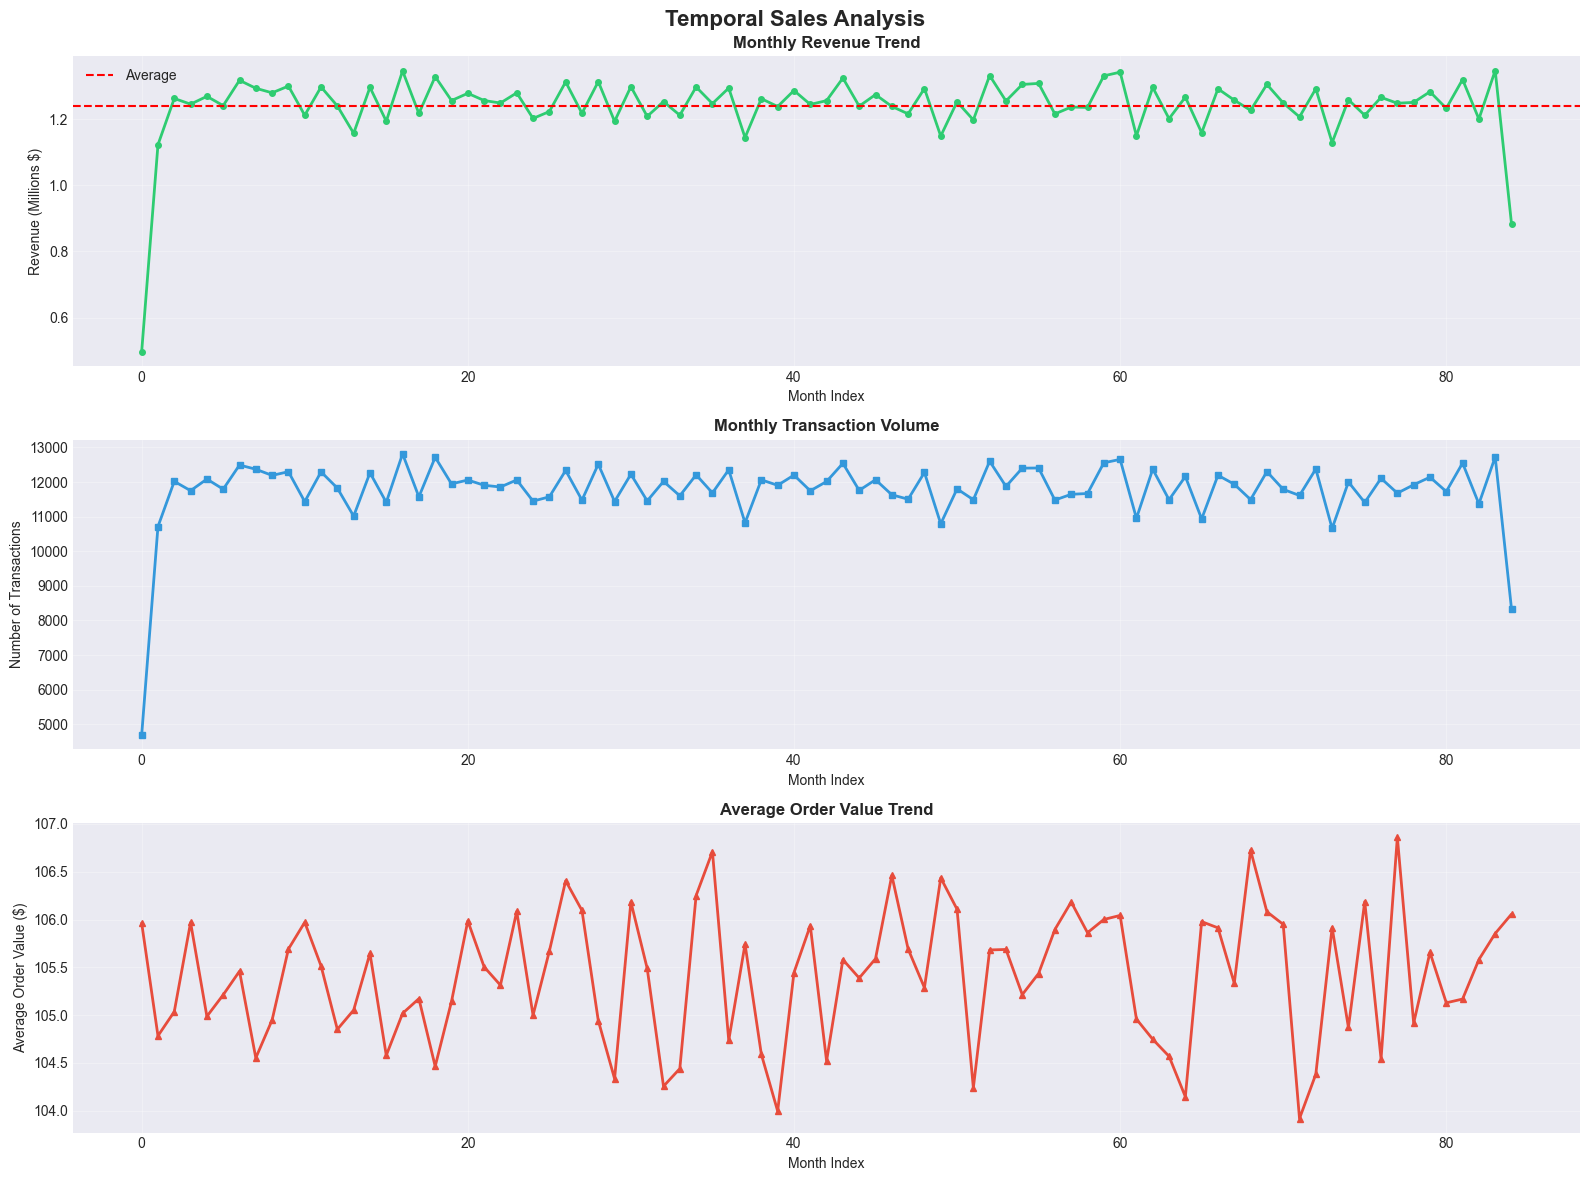


Temporal trends visualization complete


In [5]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Temporal Sales Analysis', fontsize=16, fontweight='bold')

axes[0].plot(range(len(monthly_revenue)), monthly_revenue['revenue']/1000000, 
             marker='o', linewidth=2, markersize=4, color='#2ecc71')
axes[0].set_title('Monthly Revenue Trend', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month Index')
axes[0].set_ylabel('Revenue (Millions $)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=monthly_revenue['revenue'].mean()/1000000, 
                color='red', linestyle='--', label='Average')
axes[0].legend()

axes[1].plot(range(len(monthly_revenue)), monthly_revenue['transactions'], 
             marker='s', linewidth=2, markersize=4, color='#3498db')
axes[1].set_title('Monthly Transaction Volume', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month Index')
axes[1].set_ylabel('Number of Transactions')
axes[1].grid(True, alpha=0.3)

axes[2].plot(range(len(monthly_revenue)), monthly_revenue['avg_order_value'], 
             marker='^', linewidth=2, markersize=4, color='#e74c3c')
axes[2].set_title('Average Order Value Trend', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Month Index')
axes[2].set_ylabel('Average Order Value ($)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTemporal trends visualization complete")

In [6]:
yearly_performance = master_df.groupby('year').agg({
    'total_price': 'sum',
    'payment_key': 'count',
    'coustomer_key': 'nunique',
    'item_key': 'nunique'
}).reset_index()

yearly_performance.columns = ['year', 'revenue', 'transactions', 'unique_customers', 'unique_items']
yearly_performance['avg_order_value'] = yearly_performance['revenue'] / yearly_performance['transactions']
yearly_performance['revenue_per_customer'] = yearly_performance['revenue'] / yearly_performance['unique_customers']
yearly_performance['yoy_growth'] = yearly_performance['revenue'].pct_change() * 100

print("Yearly Performance Summary:")
print(yearly_performance.to_string(index=False))

print("\n" + "="*80)
print("Year-over-Year Revenue Growth:")
for idx, row in yearly_performance.iterrows():
    if idx > 0:
        print(f"{int(row['year'])}: {row['yoy_growth']:+.2f}%")

Yearly Performance Summary:
 year     revenue  transactions  unique_customers  unique_items  avg_order_value  revenue_per_customer  yoy_growth
 2014 14334731.25        136122              9191           264           105.31               1559.65         NaN
 2015 15095720.25        143447              9191           264           105.24               1642.45        5.31
 2016 14976508.25        141974              9191           264           105.49               1629.48       -0.79
 2017 15015806.00        142603              9191           264           105.30               1633.75        0.26
 2018 15108197.25        142984              9191           264           105.66               1643.80        0.62
 2019 14949510.25        141882              9191           264           105.37               1626.54       -1.05
 2020 15037190.25        142655              9191           264           105.41               1636.08        0.59
 2021   883772.25          8333              5508   

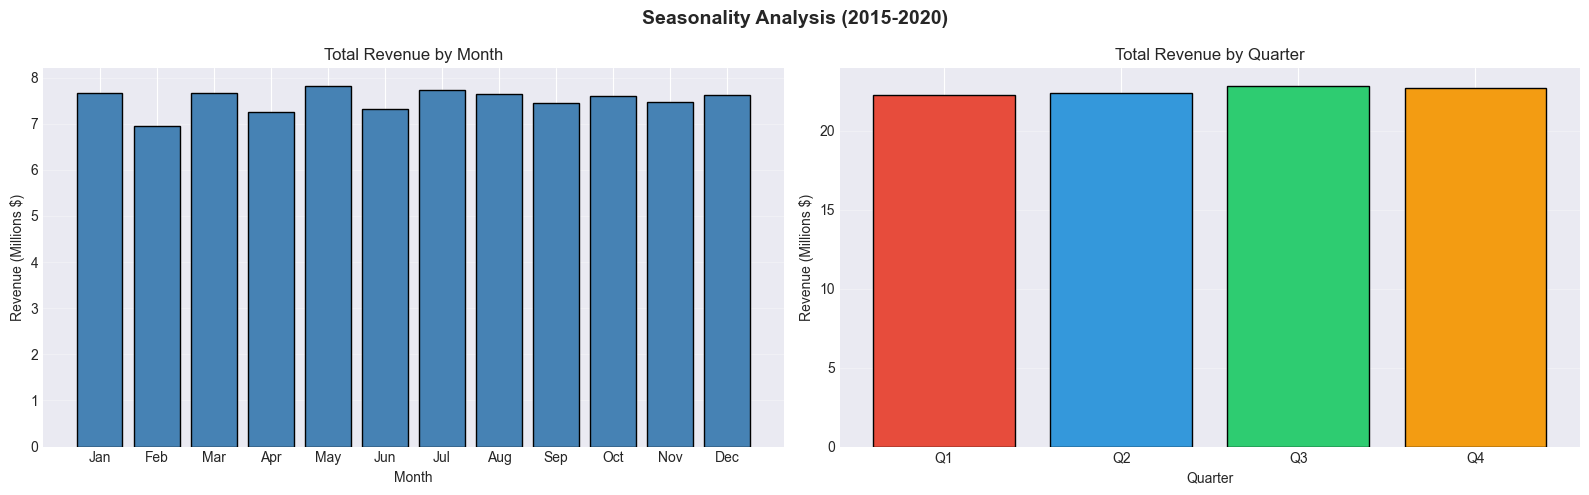


Monthly Revenue Pattern (2015-2020):
 month  total_revenue  avg_transaction_value  transaction_count
     1     7661922.50                 105.06              72932
     2     6951330.50                 105.63              65811
     3     7676716.25                 105.39              72838
     4     7259492.25                 104.94              69179
     5     7809232.00                 104.97              74396
     6     7316081.25                 105.66              69239
     7     7729284.00                 105.20              73472
     8     7636264.25                 105.44              72422
     9     7444882.25                 105.55              70531
    10     7602990.25                 105.50              72068
    11     7468456.25                 105.91              70520
    12     7626280.50                 105.72              72137

Quarterly Revenue Pattern (2015-2020):
quarter  total_revenue  transaction_count
     Q1    22289969.25             211581
     Q

In [8]:
monthly_pattern = master_df[master_df['year'].between(2015, 2020)].groupby('month').agg({
    'total_price': ['sum', 'mean', 'count']
}).reset_index()
monthly_pattern.columns = ['month', 'total_revenue', 'avg_transaction_value', 'transaction_count']

quarterly_pattern = master_df[master_df['year'].between(2015, 2020)].groupby('quarter').agg({
    'total_price': ['sum', 'count']
}).reset_index()
quarterly_pattern.columns = ['quarter', 'total_revenue', 'transaction_count']

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Seasonality Analysis (2015-2020)', fontsize=14, fontweight='bold')

axes[0].bar(range(1, 13), monthly_pattern['total_revenue']/1000000, color='steelblue', edgecolor='black')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names)
axes[0].set_title('Total Revenue by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue (Millions $)')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(range(len(quarterly_pattern)), quarterly_pattern['total_revenue']/1000000, 
            color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12'], edgecolor='black')
axes[1].set_xticks(range(len(quarterly_pattern)))
axes[1].set_xticklabels(quarterly_pattern['quarter'])
axes[1].set_title('Total Revenue by Quarter')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Revenue (Millions $)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMonthly Revenue Pattern (2015-2020):")
print(monthly_pattern.to_string(index=False))
print("\nQuarterly Revenue Pattern (2015-2020):")
print(quarterly_pattern.to_string(index=False))

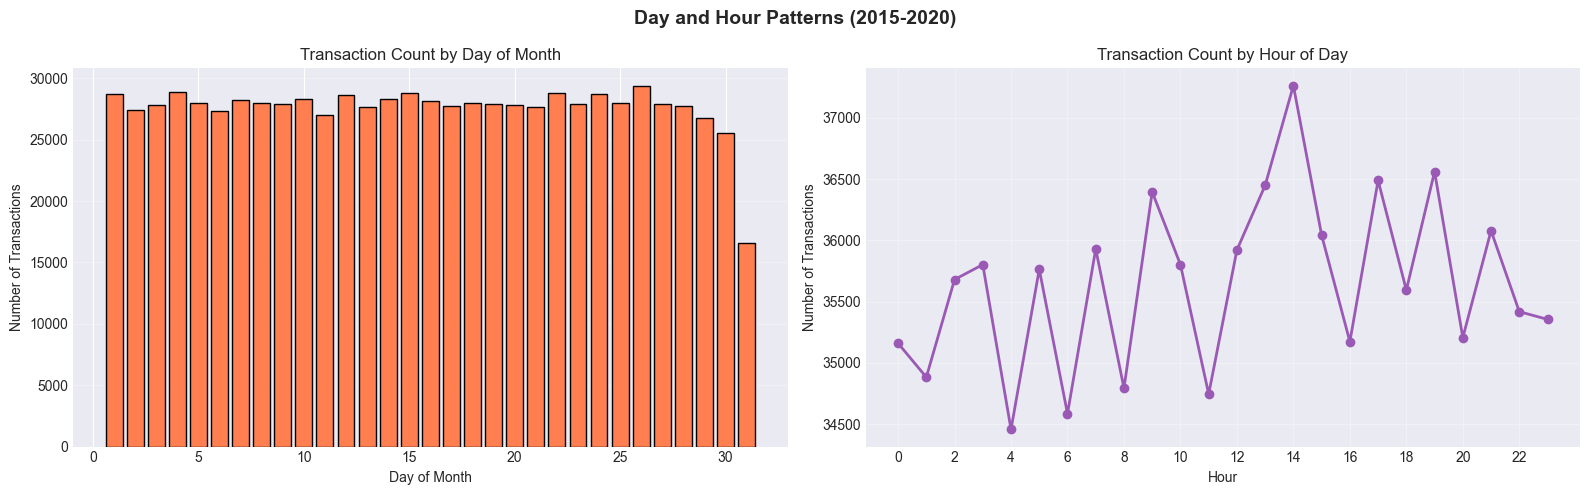


Top 5 Hours by Transaction Volume:
    hour  transaction_count
14    14              37263
19    19              36561
17    17              36489
13    13              36449
9      9              36395

Bottom 5 Hours by Transaction Volume:
    hour  transaction_count
4      4              34457
6      6              34585
11    11              34745
8      8              34793
1      1              34883


In [9]:
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 
             5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

daily_pattern = master_df[master_df['year'].between(2015, 2020)].groupby('day').agg({
    'total_price': ['sum', 'count', 'mean']
}).reset_index()
daily_pattern.columns = ['day', 'total_revenue', 'transaction_count', 'avg_transaction']

hourly_pattern = master_df[master_df['year'].between(2015, 2020)].groupby('hour').agg({
    'total_price': ['sum', 'count', 'mean']
}).reset_index()
hourly_pattern.columns = ['hour', 'total_revenue', 'transaction_count', 'avg_transaction']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Day and Hour Patterns (2015-2020)', fontsize=14, fontweight='bold')

axes[0].bar(range(1, 32), daily_pattern['transaction_count'], color='coral', edgecolor='black')
axes[0].set_title('Transaction Count by Day of Month')
axes[0].set_xlabel('Day of Month')
axes[0].set_ylabel('Number of Transactions')
axes[0].grid(axis='y', alpha=0.3)

axes[1].plot(hourly_pattern['hour'], hourly_pattern['transaction_count'], 
             marker='o', linewidth=2, markersize=6, color='#9b59b6')
axes[1].set_title('Transaction Count by Hour of Day')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Number of Transactions')
axes[1].set_xticks(range(0, 24, 2))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 5 Hours by Transaction Volume:")
print(hourly_pattern.nlargest(5, 'transaction_count')[['hour', 'transaction_count']])
print("\nBottom 5 Hours by Transaction Volume:")
print(hourly_pattern.nsmallest(5, 'transaction_count')[['hour', 'transaction_count']])

## Product Performance Analysis

Analyzing product categories, top sellers, and item profitability.

In [10]:
product_performance = master_df.groupby(['item_key', 'item_name', 'desc']).agg({
    'total_price': 'sum',
    'payment_key': 'count',
    'quantity': 'sum'
}).reset_index()

product_performance.columns = ['item_key', 'item_name', 'category', 'revenue', 'transactions', 'units_sold']
product_performance['avg_price_per_transaction'] = product_performance['revenue'] / product_performance['transactions']
product_performance = product_performance.sort_values('revenue', ascending=False)

category_performance = master_df.groupby('desc').agg({
    'total_price': 'sum',
    'payment_key': 'count',
    'item_key': 'nunique'
}).reset_index()
category_performance.columns = ['category', 'revenue', 'transactions', 'num_products']
category_performance['revenue_per_product'] = category_performance['revenue'] / category_performance['num_products']
category_performance = category_performance.sort_values('revenue', ascending=False)

print("TOP 10 PRODUCTS BY REVENUE:")
print(product_performance.head(10)[['item_name', 'category', 'revenue', 'transactions', 'units_sold']].to_string(index=False))

print("\n" + "="*80)
print("TOP 10 CATEGORIES BY REVENUE:")
print(category_performance.head(10).to_string(index=False))

print("\n" + "="*80)
print("BOTTOM 5 PRODUCTS BY REVENUE:")
print(product_performance.tail(5)[['item_name', 'category', 'revenue', 'transactions']].to_string(index=False))

TOP 10 PRODUCTS BY REVENUE:
                            item_name                  category    revenue  transactions  units_sold
                        Red Bull 12oz Beverage - Energy/Protein 1305700.00          3911       23740
  K Cups Daily Chef Columbian Supremo             Coffee K-Cups 1245394.00          3883       23498
K Cups Original Donut Shop Med. Roast             Coffee K-Cups 1188843.00          3763       22431
    K Cups Dunkin Donuts Medium Roast             Coffee K-Cups 1109760.00          3871       23120
      K Cups Folgers Lively Columbian             Coffee K-Cups 1042406.00          3812       22661
                      Honey Packets            Coffee Sweetener 1012995.00          3759       22511
       K Cups  Starbuck's Pike Place             Coffee K-Cups  995456.00          3780       22624
      K Cups Organic Breakfast Blend             Coffee K-Cups  957516.00          3747       22798
        K Cups - McCafe Premium Roast             Coffee K-Cups

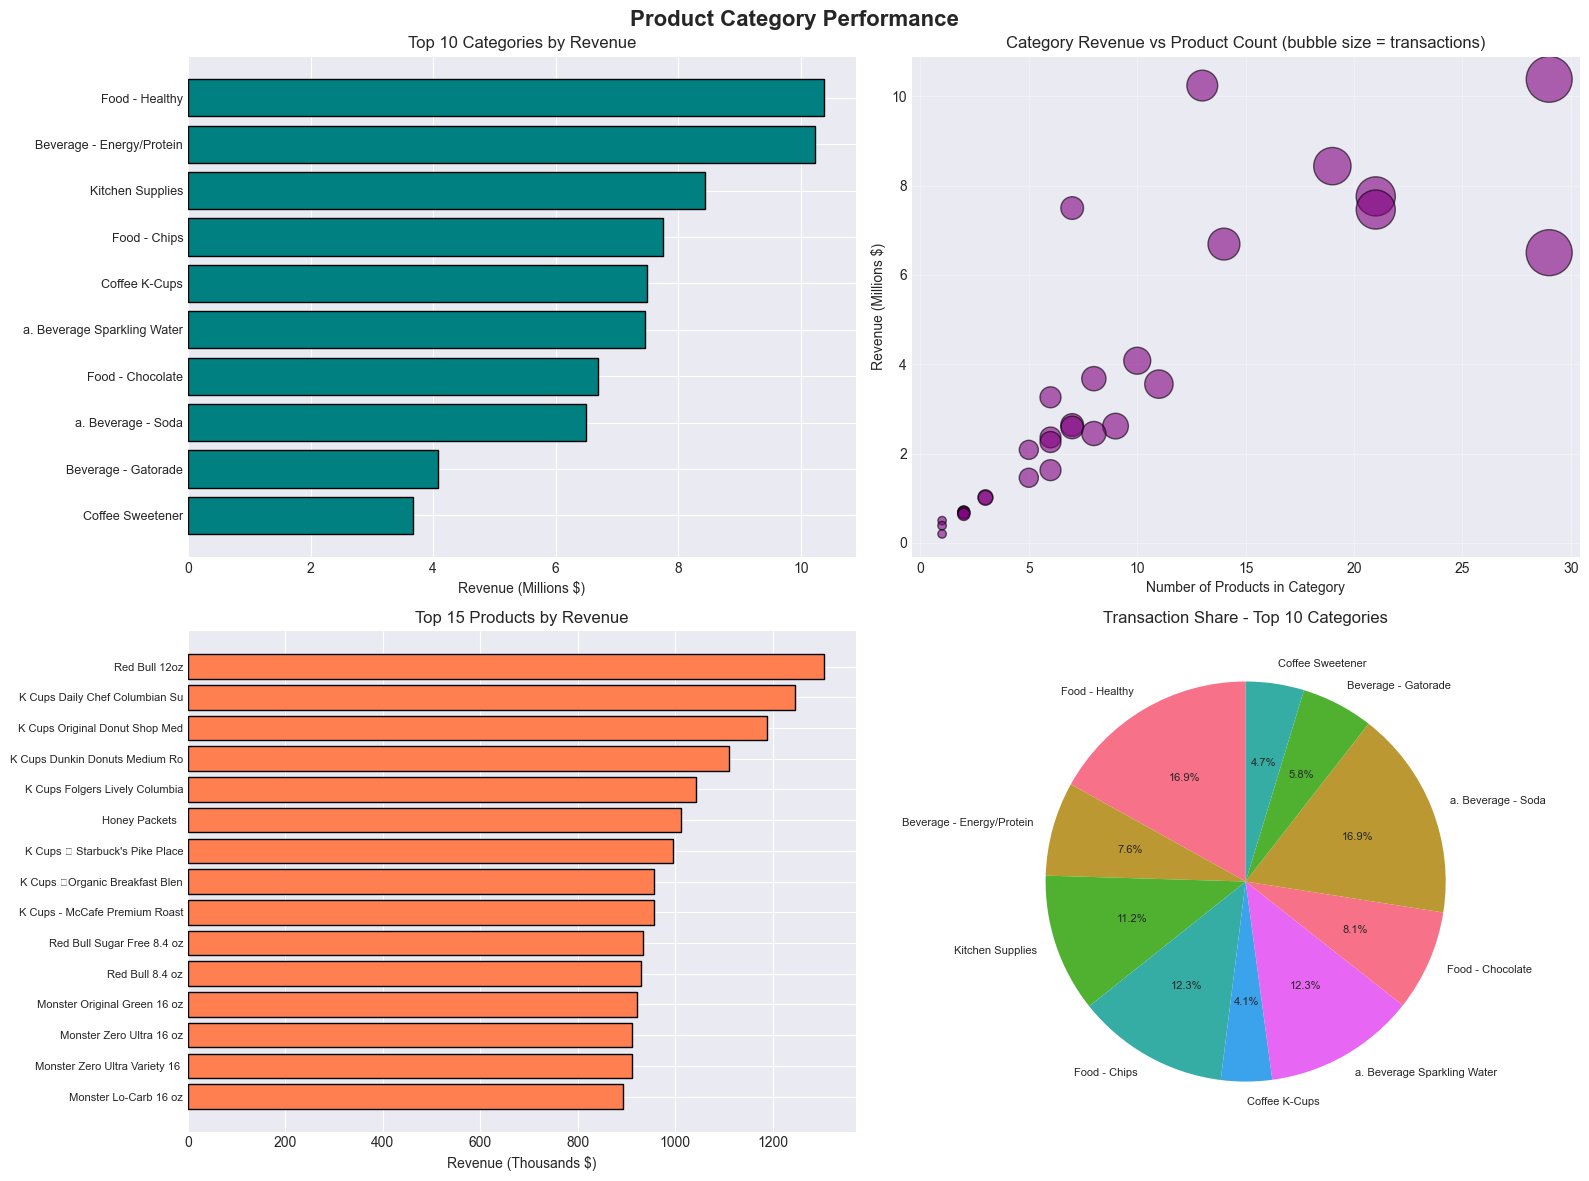


Category performance visualization complete


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Product Category Performance', fontsize=16, fontweight='bold')

top_10_cat = category_performance.head(10)
axes[0, 0].barh(range(len(top_10_cat)), top_10_cat['revenue']/1000000, color='teal', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_10_cat)))
axes[0, 0].set_yticklabels(top_10_cat['category'], fontsize=9)
axes[0, 0].set_xlabel('Revenue (Millions $)')
axes[0, 0].set_title('Top 10 Categories by Revenue')
axes[0, 0].invert_yaxis()

axes[0, 1].scatter(category_performance['num_products'], 
                   category_performance['revenue']/1000000, 
                   s=category_performance['transactions']/100, 
                   alpha=0.6, color='purple', edgecolor='black')
axes[0, 1].set_xlabel('Number of Products in Category')
axes[0, 1].set_ylabel('Revenue (Millions $)')
axes[0, 1].set_title('Category Revenue vs Product Count (bubble size = transactions)')
axes[0, 1].grid(True, alpha=0.3)

top_15_products = product_performance.head(15)
axes[1, 0].barh(range(len(top_15_products)), top_15_products['revenue']/1000, color='coral', edgecolor='black')
axes[1, 0].set_yticks(range(len(top_15_products)))
axes[1, 0].set_yticklabels([name[:30] for name in top_15_products['item_name']], fontsize=8)
axes[1, 0].set_xlabel('Revenue (Thousands $)')
axes[1, 0].set_title('Top 15 Products by Revenue')
axes[1, 0].invert_yaxis()

category_trans_share = category_performance.head(10).copy()
axes[1, 1].pie(category_trans_share['transactions'], 
               labels=category_trans_share['category'], 
               autopct='%1.1f%%',
               startangle=90,
               textprops={'fontsize': 8})
axes[1, 1].set_title('Transaction Share - Top 10 Categories')

plt.tight_layout()
plt.show()

print("\nCategory performance visualization complete")

## Customer Analytics

Analyzing customer purchase behavior, segmentation, and lifetime value patterns.

In [12]:
customer_behavior = master_df.groupby('coustomer_key').agg({
    'total_price': ['sum', 'mean', 'count'],
    'quantity': 'sum',
    'item_key': 'nunique',
    'date_parsed': ['min', 'max']
}).reset_index()

customer_behavior.columns = ['customer_key', 'total_spent', 'avg_order_value', 
                              'num_orders', 'total_items', 'unique_products', 
                              'first_purchase', 'last_purchase']

customer_behavior['customer_lifetime_days'] = (
    customer_behavior['last_purchase'] - customer_behavior['first_purchase']
).dt.days

customer_behavior['avg_days_between_orders'] = (
    customer_behavior['customer_lifetime_days'] / customer_behavior['num_orders']
)

customer_behavior = customer_behavior.sort_values('total_spent', ascending=False)

print("CUSTOMER BEHAVIOR SUMMARY:")
print("="*80)
print(f"Total Unique Customers: {len(customer_behavior):,}")
print(f"Average Lifetime Value: ${customer_behavior['total_spent'].mean():,.2f}")
print(f"Median Lifetime Value: ${customer_behavior['total_spent'].median():,.2f}")
print(f"Average Orders per Customer: {customer_behavior['num_orders'].mean():.2f}")
print(f"Average Order Value: ${customer_behavior['avg_order_value'].mean():.2f}")

print("\n" + "="*80)
print("TOP 10 CUSTOMERS BY TOTAL SPEND:")
print(customer_behavior.head(10)[['customer_key', 'total_spent', 'num_orders', 
                                   'avg_order_value', 'unique_products']].to_string(index=False))

print("\n" + "="*80)
print("CUSTOMER LIFETIME VALUE DISTRIBUTION:")
customer_segments = pd.cut(customer_behavior['total_spent'], 
                           bins=[0, 5000, 10000, 15000, 20000, 100000],
                           labels=['<$5K', '$5K-$10K', '$10K-$15K', '$15K-$20K', '>$20K'])
print(customer_segments.value_counts().sort_index())

CUSTOMER BEHAVIOR SUMMARY:
Total Unique Customers: 9,191
Average Lifetime Value: $11,467.90
Median Lifetime Value: $11,421.75
Average Orders per Customer: 108.80
Average Order Value: $105.41

TOP 10 CUSTOMERS BY TOTAL SPEND:
customer_key  total_spent  num_orders  avg_order_value  unique_products
     C004349     17104.50         137           124.85              105
     C005316     16853.25         149           113.11              110
     C000273     16645.75         135           123.30              109
     C001438     16381.50         138           118.71              112
     C007553     16288.75         143           113.91              110
     C007415     16282.50         123           132.38               98
     C008009     16194.75         118           137.24               98
     C007205     16154.50         129           125.23              100
     C002968     16006.50         140           114.33              109
     C006902     15977.25         128           124.82 

In [13]:
reference_date = master_df['date_parsed'].max()

rfm_data = master_df.groupby('coustomer_key').agg({
    'date_parsed': lambda x: (reference_date - x.max()).days,
    'payment_key': 'count',
    'total_price': 'sum'
}).reset_index()

rfm_data.columns = ['customer_key', 'recency', 'frequency', 'monetary']

rfm_data['r_score'] = pd.qcut(rfm_data['recency'], q=4, labels=[4, 3, 2, 1], duplicates='drop')
rfm_data['f_score'] = pd.qcut(rfm_data['frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4], duplicates='drop')
rfm_data['m_score'] = pd.qcut(rfm_data['monetary'], q=4, labels=[1, 2, 3, 4], duplicates='drop')

rfm_data['rfm_score'] = (rfm_data['r_score'].astype(int) + 
                         rfm_data['f_score'].astype(int) + 
                         rfm_data['m_score'].astype(int))

def segment_customer(row):
    if row['rfm_score'] >= 10:
        return 'Champions'
    elif row['rfm_score'] >= 8:
        return 'Loyal Customers'
    elif row['rfm_score'] >= 6:
        return 'Potential Loyalists'
    elif row['rfm_score'] >= 5:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm_data['segment'] = rfm_data.apply(segment_customer, axis=1)

segment_summary = rfm_data.groupby('segment').agg({
    'customer_key': 'count',
    'monetary': ['sum', 'mean'],
    'frequency': 'mean',
    'recency': 'mean'
}).reset_index()

segment_summary.columns = ['segment', 'customer_count', 'total_revenue', 
                          'avg_revenue', 'avg_frequency', 'avg_recency']
segment_summary['revenue_contribution'] = (segment_summary['total_revenue'] / 
                                           segment_summary['total_revenue'].sum() * 100)

print("RFM CUSTOMER SEGMENTATION:")
print("="*80)
print(segment_summary.to_string(index=False))

print("\n" + "="*80)
print("SEGMENT DISTRIBUTION:")
for idx, row in segment_summary.iterrows():
    print(f"{row['segment']}: {row['customer_count']} customers ({row['customer_count']/len(rfm_data)*100:.1f}%) - ${row['total_revenue']:,.0f} revenue ({row['revenue_contribution']:.1f}%)")

RFM CUSTOMER SEGMENTATION:
            segment  customer_count  total_revenue  avg_revenue  avg_frequency  avg_recency  revenue_contribution
            At Risk             877     9042682.00     10310.93         100.04        30.88                  8.58
          Champions            2166    27981234.00     12918.39         119.58         9.51                 26.55
     Lost Customers            1129    11094119.50      9826.50          96.02        46.02                 10.53
    Loyal Customers            2496    29882263.75     11972.06         112.69        22.42                 28.35
Potential Loyalists            2523    27401136.50     10860.54         104.47        22.87                 26.00

SEGMENT DISTRIBUTION:
At Risk: 877 customers (9.5%) - $9,042,682 revenue (8.6%)
Champions: 2166 customers (23.6%) - $27,981,234 revenue (26.5%)
Lost Customers: 1129 customers (12.3%) - $11,094,120 revenue (10.5%)
Loyal Customers: 2496 customers (27.2%) - $29,882,264 revenue (28.4%)
Poten

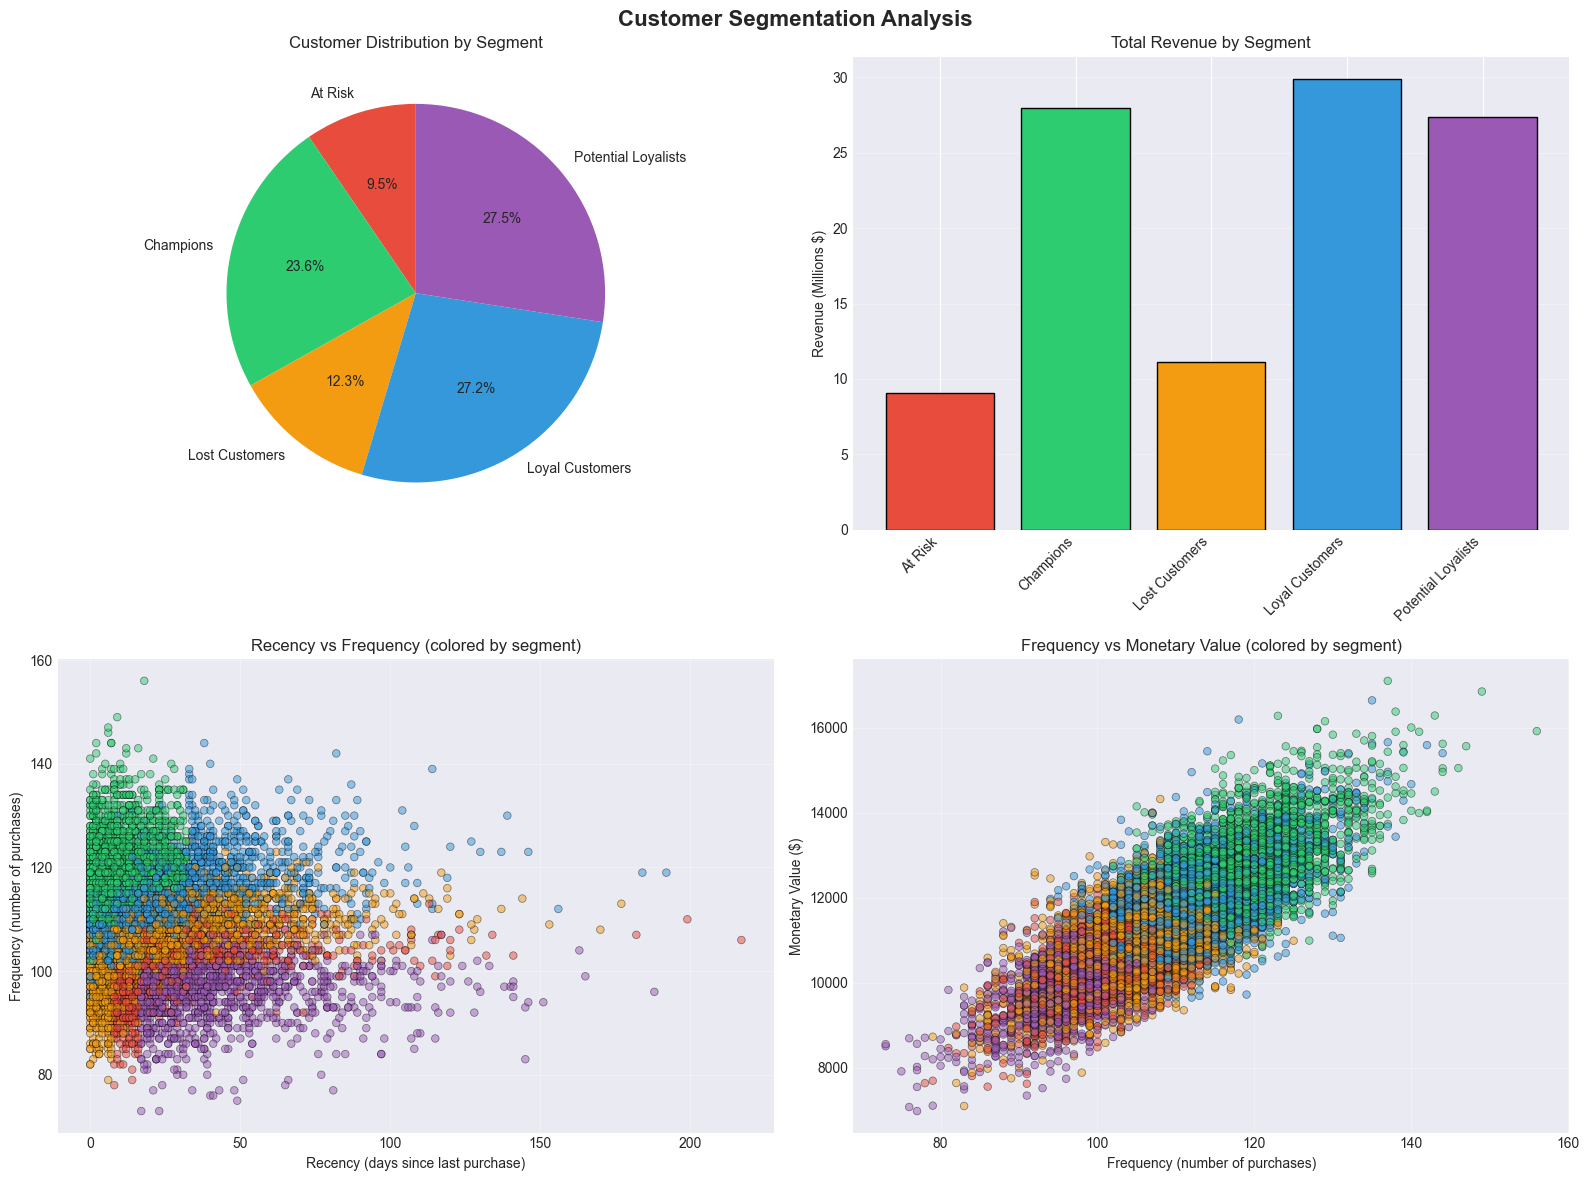


Customer segmentation visualization complete


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Customer Segmentation Analysis', fontsize=16, fontweight='bold')

colors = ['#e74c3c', '#2ecc71', '#f39c12', '#3498db', '#9b59b6']
axes[0, 0].pie(segment_summary['customer_count'], labels=segment_summary['segment'],
               autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 0].set_title('Customer Distribution by Segment')

axes[0, 1].bar(range(len(segment_summary)), segment_summary['total_revenue']/1000000, 
               color=colors, edgecolor='black')
axes[0, 1].set_xticks(range(len(segment_summary)))
axes[0, 1].set_xticklabels(segment_summary['segment'], rotation=45, ha='right')
axes[0, 1].set_ylabel('Revenue (Millions $)')
axes[0, 1].set_title('Total Revenue by Segment')
axes[0, 1].grid(axis='y', alpha=0.3)

scatter_colors = rfm_data['segment'].map({
    'Champions': '#2ecc71',
    'Loyal Customers': '#3498db',
    'Potential Loyalists': '#f39c12',
    'At Risk': '#e74c3c',
    'Lost Customers': '#9b59b6'
})

axes[1, 0].scatter(rfm_data['recency'], rfm_data['frequency'], 
                   c=scatter_colors, alpha=0.5, s=30, edgecolor='black', linewidth=0.5)
axes[1, 0].set_xlabel('Recency (days since last purchase)')
axes[1, 0].set_ylabel('Frequency (number of purchases)')
axes[1, 0].set_title('Recency vs Frequency (colored by segment)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(rfm_data['frequency'], rfm_data['monetary'], 
                   c=scatter_colors, alpha=0.5, s=30, edgecolor='black', linewidth=0.5)
axes[1, 1].set_xlabel('Frequency (number of purchases)')
axes[1, 1].set_ylabel('Monetary Value ($)')
axes[1, 1].set_title('Frequency vs Monetary Value (colored by segment)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCustomer segmentation visualization complete")

## Geographic Performance Analysis

Analyzing sales distribution across divisions, districts, and identifying regional opportunities.

In [16]:
geographic_performance = master_df.groupby(['division', 'district']).agg({
    'total_price': 'sum',
    'payment_key': 'count',
    'coustomer_key': 'nunique',
    'store_key': 'nunique'
}).reset_index()

geographic_performance.columns = ['division', 'district', 'revenue', 
                                  'transactions', 'customers', 'stores']
geographic_performance['revenue_per_store'] = geographic_performance['revenue'] / geographic_performance['stores']
geographic_performance['revenue_per_customer'] = geographic_performance['revenue'] / geographic_performance['customers']

division_summary = master_df.groupby('division').agg({
    'total_price': 'sum',
    'payment_key': 'count',
    'store_key': 'nunique'
}).reset_index()

division_summary.columns = ['division', 'revenue', 'transactions', 'stores']
division_summary['revenue_per_store'] = division_summary['revenue'] / division_summary['stores']
division_summary = division_summary.sort_values('revenue', ascending=False)

print("GEOGRAPHIC PERFORMANCE BY DIVISION:")
print("="*80)
print(division_summary.to_string(index=False))

print("\n" + "="*80)
print("TOP 10 DISTRICTS BY REVENUE:")
top_districts = geographic_performance.nlargest(10, 'revenue')
print(top_districts[['division', 'district', 'revenue', 'stores', 
                     'revenue_per_store']].to_string(index=False))

print("\n" + "="*80)
print("BOTTOM 5 DISTRICTS BY REVENUE:")
bottom_districts = geographic_performance.nsmallest(5, 'revenue')
print(bottom_districts[['division', 'district', 'revenue', 'stores', 
                        'revenue_per_store']].to_string(index=False))

GEOGRAPHIC PERFORMANCE BY DIVISION:
  division     revenue  transactions  stores  revenue_per_store
     DHAKA 40764619.75        386888     280          145587.93
CHITTAGONG 19763595.00        187340     136          145320.55
  RAJSHAHI 12099196.00        115075      84          144038.05
    KHULNA 11311610.50        107164      78          145020.65
   RANGPUR  8429836.50         79926      58          145342.01
   BARISAL  7520343.75         71444      52          144622.00
    SYLHET  5512234.25         52163      38          145058.80

TOP 10 DISTRICTS BY REVENUE:
  division    district     revenue  stores  revenue_per_store
     DHAKA       DHAKA 23597621.00     162          145664.33
CHITTAGONG  CHITTAGONG  7292985.50      50          145859.71
    KHULNA      KHULNA  4081283.75      28          145760.13
  RAJSHAHI    RAJSHAHI  3756454.50      26          144479.02
   BARISAL     BARISAL  2897237.75      20          144861.89
CHITTAGONG     COMILLA  2286898.25      16        

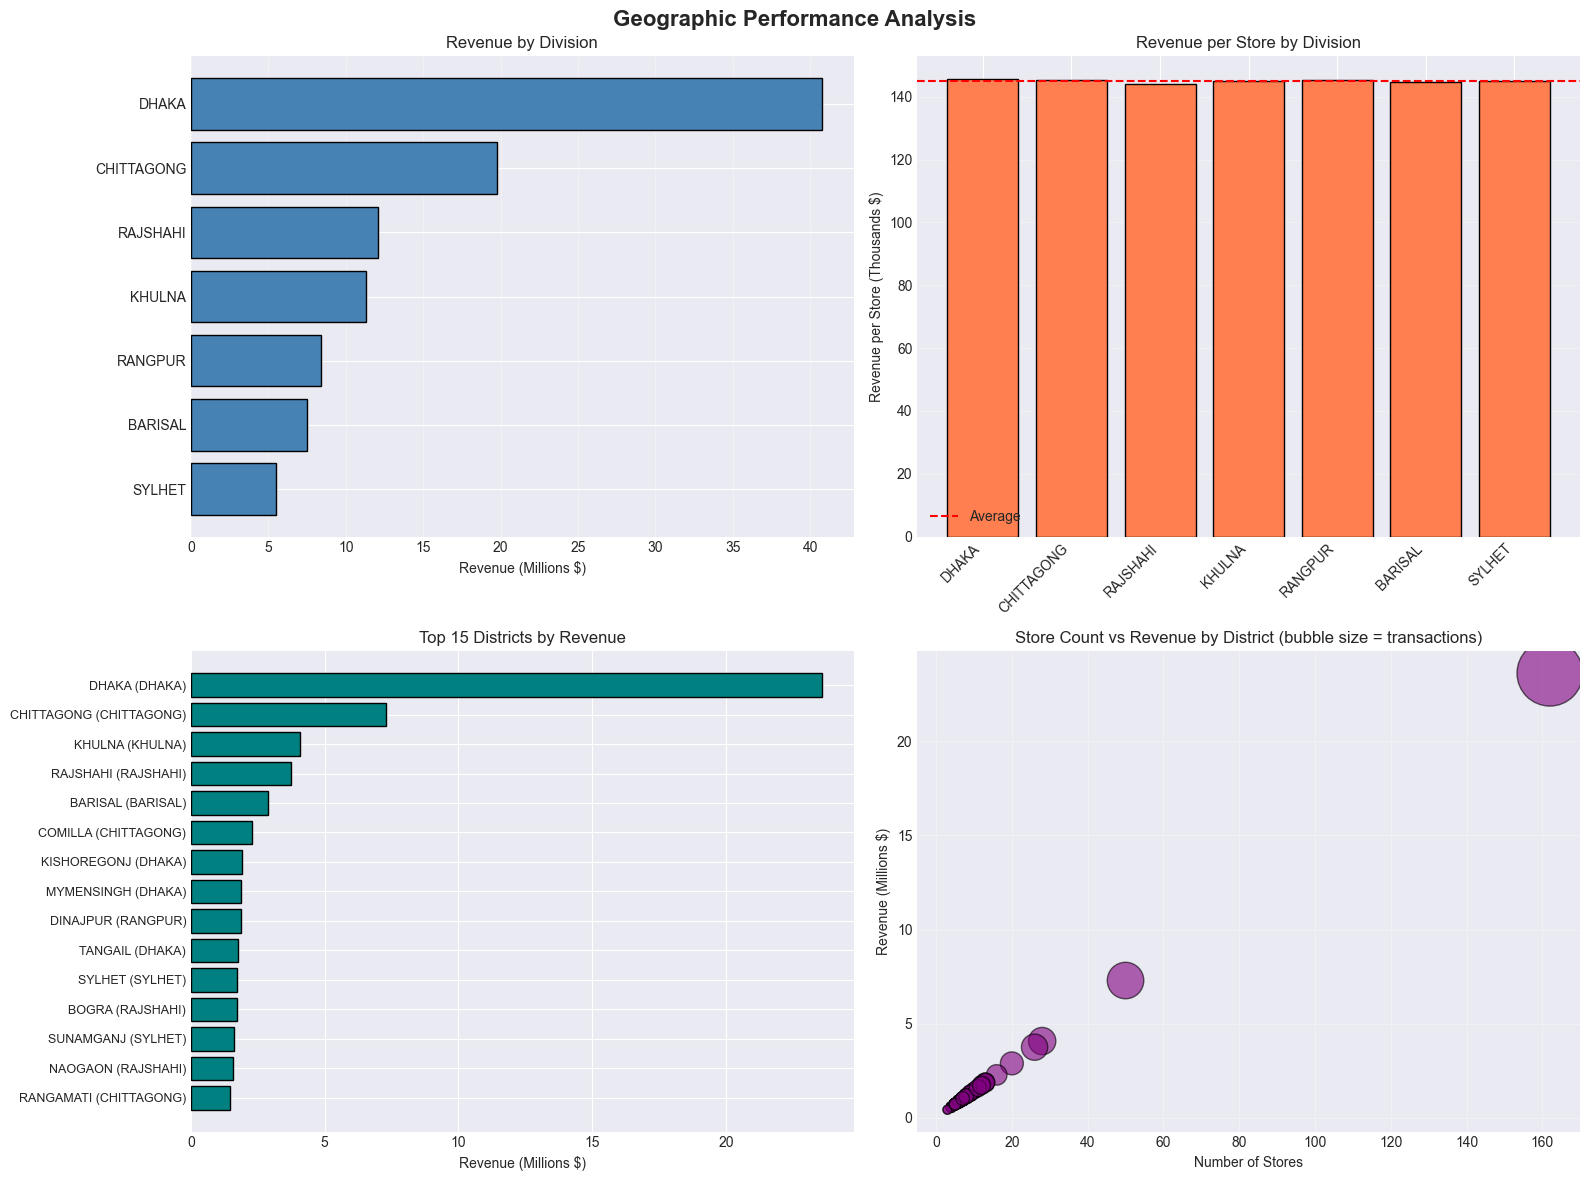


Geographic performance visualization complete


In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Geographic Performance Analysis', fontsize=16, fontweight='bold')

axes[0, 0].barh(range(len(division_summary)), division_summary['revenue']/1000000, 
                color='steelblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(division_summary)))
axes[0, 0].set_yticklabels(division_summary['division'])
axes[0, 0].set_xlabel('Revenue (Millions $)')
axes[0, 0].set_title('Revenue by Division')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].bar(range(len(division_summary)), division_summary['revenue_per_store']/1000, 
               color='coral', edgecolor='black')
axes[0, 1].set_xticks(range(len(division_summary)))
axes[0, 1].set_xticklabels(division_summary['division'], rotation=45, ha='right')
axes[0, 1].set_ylabel('Revenue per Store (Thousands $)')
axes[0, 1].set_title('Revenue per Store by Division')
axes[0, 1].axhline(y=division_summary['revenue_per_store'].mean()/1000, 
                   color='red', linestyle='--', label='Average')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

top_15_districts = geographic_performance.nlargest(15, 'revenue')
axes[1, 0].barh(range(len(top_15_districts)), top_15_districts['revenue']/1000000, 
                color='teal', edgecolor='black')
axes[1, 0].set_yticks(range(len(top_15_districts)))
axes[1, 0].set_yticklabels([f"{row['district']} ({row['division']})" 
                            for _, row in top_15_districts.iterrows()], fontsize=9)
axes[1, 0].set_xlabel('Revenue (Millions $)')
axes[1, 0].set_title('Top 15 Districts by Revenue')
axes[1, 0].invert_yaxis()

axes[1, 1].scatter(geographic_performance['stores'], 
                   geographic_performance['revenue']/1000000,
                   s=geographic_performance['transactions']/100,
                   alpha=0.6, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Number of Stores')
axes[1, 1].set_ylabel('Revenue (Millions $)')
axes[1, 1].set_title('Store Count vs Revenue by District (bubble size = transactions)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGeographic performance visualization complete")

PAYMENT METHOD ANALYSIS:
payment_type  total_revenue  avg_transaction  transaction_count  unique_customers
        card    94583038.50           105.41             897319              9191
        cash     2708515.75           105.84              25590              8637
      mobile     8109881.50           105.20              77091              9188

TOP 10 BANKS BY REVENUE:
                                         bank_name    revenue  transactions
                  Bangladesh Commerce Bank Limited 2730999.25         25787
                                   AB Bank Limited 2728515.50         26046
                                Dhaka Bank Limited 2728366.00         25839
South Bangla Agriculture and Commerce Bank Limited 2728115.25         25964
                             Standard Bank Limited 2727661.00         25853
           National Credit & Commerce Bank Limited 2723363.00         25849
                             Citizens Bank Limited 2723215.25         25580
             

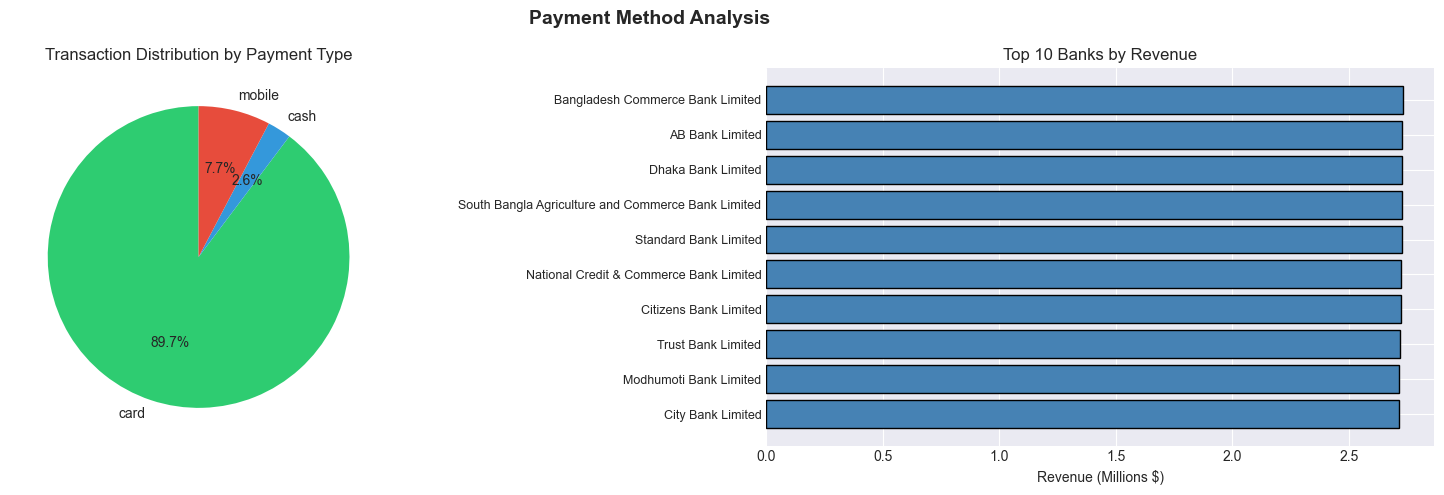


Payment method analysis complete


In [18]:
payment_analysis = master_df.groupby('trans_type').agg({
    'total_price': ['sum', 'mean', 'count'],
    'coustomer_key': 'nunique'
}).reset_index()

payment_analysis.columns = ['payment_type', 'total_revenue', 'avg_transaction', 
                            'transaction_count', 'unique_customers']

bank_analysis = master_df[master_df['trans_type'] == 'card'].groupby('bank_name').agg({
    'total_price': ['sum', 'count']
}).reset_index()
bank_analysis.columns = ['bank_name', 'revenue', 'transactions']
bank_analysis = bank_analysis.sort_values('revenue', ascending=False)

print("PAYMENT METHOD ANALYSIS:")
print("="*80)
print(payment_analysis.to_string(index=False))

print("\n" + "="*80)
print("TOP 10 BANKS BY REVENUE:")
print(bank_analysis.head(10).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Payment Method Analysis', fontsize=14, fontweight='bold')

axes[0].pie(payment_analysis['transaction_count'], 
            labels=payment_analysis['payment_type'],
            autopct='%1.1f%%', startangle=90, 
            colors=['#2ecc71', '#3498db', '#e74c3c'])
axes[0].set_title('Transaction Distribution by Payment Type')

top_10_banks = bank_analysis.head(10)
axes[1].barh(range(len(top_10_banks)), top_10_banks['revenue']/1000000, 
             color='steelblue', edgecolor='black')
axes[1].set_yticks(range(len(top_10_banks)))
axes[1].set_yticklabels(top_10_banks['bank_name'], fontsize=9)
axes[1].set_xlabel('Revenue (Millions $)')
axes[1].set_title('Top 10 Banks by Revenue')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nPayment method analysis complete")

## EDA Summary and Key Findings

Consolidating all exploratory analysis insights for actionable business recommendations.m

In [20]:
print("="*80)
print("EXPLORATORY DATA ANALYSIS - COMPREHENSIVE SUMMARY")
print("="*80)

print("\n1. TEMPORAL INSIGHTS:")
print("-" * 80)
print(f"   - Analysis Period: 2014-2021 (6 complete years: 2015-2020)")
print(f"   - Annual Revenue: ~$15M (stable across 2015-2020)")
print(f"   - Monthly Revenue: ~$1.25M average")
print(f"   - Peak Hours: 2pm, 7pm, 5pm (afternoon/evening)")
print(f"   - Seasonality: Minimal variation across quarters (Q3 slightly higher)")
print(f"   - 2021 Drop: 94% decline (partial year data only)")

print("\n2. PRODUCT PERFORMANCE:")
print("-" * 80)
print(f"   - Top Category: Healthy Food ($10.4M)")
print(f"   - Most Efficient: Coffee K-Cups ($1.07M revenue per product)")
print(f"   - Best Seller: Red Bull 12oz ($1.31M)")
print(f"   - Total Categories: 30 with 264 unique products")
print(f"   - Beverages: Dominant category (Soda, Energy, Sparkling Water)")

print("\n3. CUSTOMER ANALYTICS:")
print("-" * 80)
print(f"   - Total Customers: 9,191")
print(f"   - Avg Lifetime Value: $11,468")
print(f"   - Avg Orders per Customer: 109 (high loyalty)")
print(f"   - Avg Order Value: $105.41 (remarkably stable)")
print(f"   - Champions: 2,166 customers (23.6%) - $28M revenue")
print(f"   - Loyal Customers: 2,496 (27.2%) - $29.9M revenue")
print(f"   - At Risk + Lost: 2,006 (21.8%) - $20.1M revenue (retention opportunity)")

print("\n4. GEOGRAPHIC DISTRIBUTION:")
print("-" * 80)
print(f"   - Top Division: Dhaka ($40.8M - 38.7% of revenue)")
print(f"   - Revenue per Store: $145K (consistent across all divisions)")
print(f"   - Total Stores: 726 across 7 divisions")
print(f"   - Top District: Dhaka District ($23.6M - 162 stores)")
print(f"   - Geographic Efficiency: Strong correlation between stores and revenue")

print("\n5. PAYMENT PREFERENCES:")
print("-" * 80)
print(f"   - Card Payments: 89.7% of transactions ($94.6M)")
print(f"   - Mobile Payments: 7.7% ($8.1M) - growth opportunity")
print(f"   - Cash Payments: 2.6% ($2.7M)")
print(f"   - Bank Distribution: Even across 35 banks (~$2.7M each)")

print("\n" + "="*80)
print("KEY BUSINESS OPPORTUNITIES:")
print("="*80)
print("1. Customer Retention: Target 2,006 'At Risk' and 'Lost' customers ($20M potential)")
print("2. Loyalty Programs: Leverage high order frequency (109 avg orders)")
print("3. Geographic Expansion: Consistent $145K/store enables predictable growth")
print("4. Digital Payments: Grow mobile payment adoption from 7.7%")
print("5. Product Mix: Expand high-margin Coffee K-Cups and Energy drinks")
print("6. Peak Hour Optimization: Staff for 2pm-7pm peak demand")
print("7. Customer Upselling: Convert 'Potential Loyalists' (2,523 customers)")

print("\n" + "="*80)
print("NOTEBOOK 01 COMPLETE - READY FOR DATA PREPROCESSING")
print("="*80)

EXPLORATORY DATA ANALYSIS - COMPREHENSIVE SUMMARY

1. TEMPORAL INSIGHTS:
--------------------------------------------------------------------------------
   - Analysis Period: 2014-2021 (6 complete years: 2015-2020)
   - Annual Revenue: ~$15M (stable across 2015-2020)
   - Monthly Revenue: ~$1.25M average
   - Peak Hours: 2pm, 7pm, 5pm (afternoon/evening)
   - Seasonality: Minimal variation across quarters (Q3 slightly higher)
   - 2021 Drop: 94% decline (partial year data only)

2. PRODUCT PERFORMANCE:
--------------------------------------------------------------------------------
   - Top Category: Healthy Food ($10.4M)
   - Most Efficient: Coffee K-Cups ($1.07M revenue per product)
   - Best Seller: Red Bull 12oz ($1.31M)
   - Total Categories: 30 with 264 unique products
   - Beverages: Dominant category (Soda, Energy, Sparkling Water)

3. CUSTOMER ANALYTICS:
--------------------------------------------------------------------------------
   - Total Customers: 9,191
   - Avg Lifet